### $\color{red}{\text{LAB 03 :  Image Processing }}$

#### $\color{black}{\text{Made by : Zahra BENSLIMANE}}$

Prof. Daniel Racoceanu
Sorbonne Université, Faculté des Sciences et Ingénierie

***

In [1]:
# Importing the libraries
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import random
from PIL import Image  
from skimage.color import rgb2gray, label2rgb
from skimage.draw import polygon, circle_perimeter, disk
from skimage.measure import label, regionprops, regionprops_table, find_contours, approximate_polygon
from skimage.feature import corner_harris, corner_subpix, corner_peaks
import math
from skimage import feature
from skimage import measure
import pandas as pd


In [2]:
imageFolder = "Images_TP"

---
### photomaton : 

Look carefully at the series of 9 images 1,2,3,4,5,6,7..12. Each was
obtained from the previous one by reducing the size of the image by half,
which gave four analogous pieces that have been placed in a square to
obtain an image having the same size as the original image. The number
of pixels has been exactly preserved and in fact, we have only moved
each of the pixels (without changing the color). Precisely we cut the initial
image into square packets of four pixels (2x2), then for each square packet
of four pixels, we used the one from the top left for the reduced image of
Mona Lisa in the top left, the one in top right for the top right image of Mona
Lisa, etc. This operation produced four reduced versions of Mona Lisa. This
transformation is called the photo booth transformation. Image B has 4
Mona Lisa. Image C has 16. Image D has 64, etc. Something strange is
happening because, after nine steps, the image of Mona Lisa has
reappeared. Note that it is the same transformation that was used to
deduce one after the other the images of the series.

In [3]:
def strip(img):
    L, H = img.shape[0],img.shape[1]
    crop_image = np.zeros(img.shape)

    if(L%2 != 0):
        crop_image = img[0:L-1, 0:H]
    if(H%2 != 0):
        crop_image = crop_image[:, 0:H-1]
        
    return crop_image

def photomaton(img):
    L, H = img.shape[0],img.shape[1]
    I = np.zeros(img.shape)

    # Loop through the image with 2 pixels at a time
    for j in range(0,H,2):
        for i in range(0,L,2):
            #print("i = ",i,"i = ",j)
            I[i//2, j//2,:] = img[i,j,:]
            I[(L + i)//2, j//2,:] = img[i+1,j,:]
            I[(L + i)//2, (H + j)//2,:] = img[i+1,j+1,:]
            I[i//2,(H + j)//2,:] = img[i,j+1,:] 
    return I


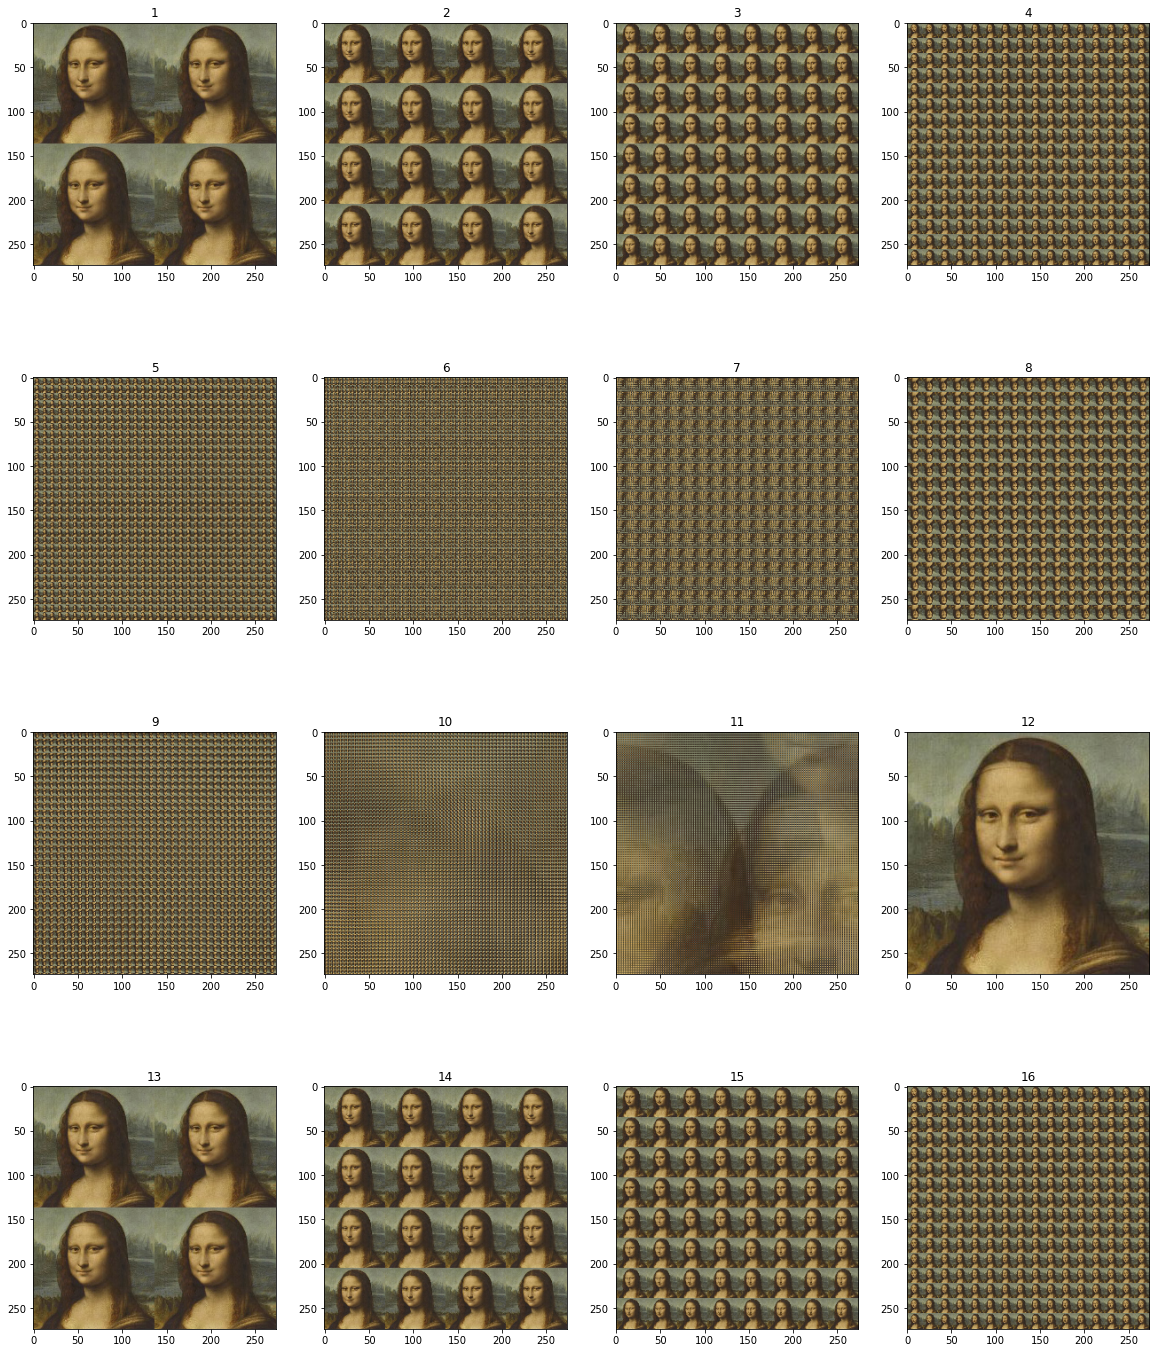

In [4]:
# Loading an image
I = cv.imread(imageFolder+"/MonaLisa_square.jpg",cv.IMREAD_COLOR)

plt.figure(figsize=(20,25))
for i in range(16):
    res = photomaton(I)
    plt.subplot(4,4,i+1)
    plt.imshow(cv.cvtColor(res.astype(np.uint8), cv.COLOR_BGR2RGB)) 
    plt.title(str(i+1))
    I = res.copy()
    

<div class="alert alert-info">
    

### Comments :
    
* It is important to note that the 4 images that appear after a transformation step are not identical.
* This transformation only works with images whose height and width are even.
* If we repeat this transformation a certain number of times, we find the starting image. The number of iterations is called the return period.
    
    
</div>



---

### **Flags:** 
a few hours after the Paris attacks of November 13, 2015, Facebook
activated a temporary option to dress the profile photos of its users in the
colors of the French flag. Very quickly, the social network was colored blue,
white, red to show its solidarity with the victims. Fortunately, this process
could be used in less dramatic circumstances, for example to show support
for your favorite sports team.

Overlay one of the flags below (or others) on an image. For Croatia, we will
just reproduce red and white checkerboard.

flag.shape =  (187, 122)
image.shape =  (216, 216, 3)


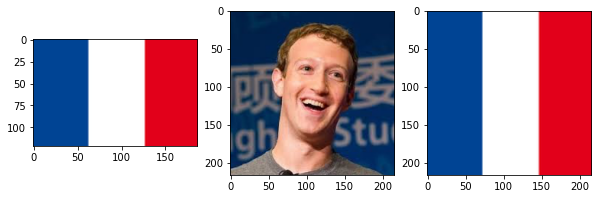

In [5]:
# Loading an image
I = cv.imread(imageFolder+"/Mark.png",cv.IMREAD_COLOR)

# Loading an flag
flag = Image.open(imageFolder+"/France.png")
                 
print("flag.shape = ",flag.size)
print("image.shape = ",I.shape)

from skimage.transform import resize

def resizeFlag(I,flag):
    res = np.zeros(I.shape) 
    
    I_cols,I_rows,I_chanels = I.shape
    flag_cols,flag_rows = flag.size
    
    if I_cols != flag_cols or I_rows != flag_rows:
        return cv.cvtColor(np.array(flag.resize( (I_cols,I_rows)) ), cv.COLOR_RGB2BGR) 
    else:
        return cv.cvtColor(np.array(flag), cv.COLOR_RGB2BGR)
        
flag2 = resizeFlag(I,flag)

plt.figure(figsize=(10,5))
plt.subplot(1,3,1); plt.imshow(np.array(flag)) 
plt.subplot(1,3,2); plt.imshow(cv.cvtColor(I.astype(np.uint8), cv.COLOR_BGR2RGB)) 
plt.subplot(1,3,3); plt.imshow(cv.cvtColor(flag2.astype(np.uint8), cv.COLOR_BGR2RGB))    


<div class="alert alert-info">
    
Since the flag and the image are in different shapes, we had to resize the flag to the same shape as the image to be able to overlay them together
     
</div>


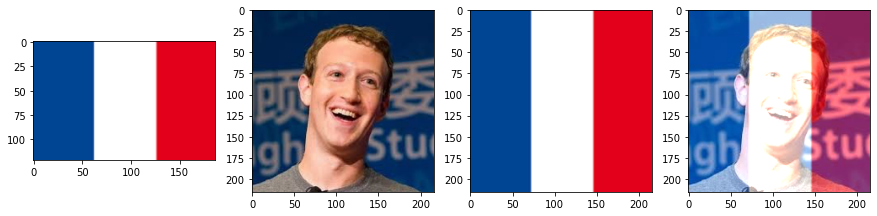

In [6]:
def insertFlag(img,flag):
    I = np.zeros(img.shape)
    L, H = img.shape[0],img.shape[1]
    
    # Loop through the image 
    for j in range(H):
        for i in range(L):
            for k in range(3):
                I[i,j,k] = flag[i,j,k]*0.6  + img[i,j,k]
                if  I[i,j,k] > 255 : I[i,j,k] = 255
            
    return I.astype(np.uint8)
    
output = insertFlag(I,flag2)
plt.figure(figsize=(15,5))
plt.subplot(1,4,1); plt.imshow(np.array(flag)) 
plt.subplot(1,4,2); plt.imshow(cv.cvtColor(I.astype(np.uint8), cv.COLOR_BGR2RGB)) 
plt.subplot(1,4,3); plt.imshow(cv.cvtColor(flag2.astype(np.uint8), cv.COLOR_BGR2RGB))  
plt.subplot(1,4,4); plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))  


<div class="alert alert-info">
    

### Comments :

* Probably not the best result to have, since the white is predominant in the image. And if we give more weight to the original image, the red and blue colors might not be as vibrant as they are in this case.
    
* The idea that i give is to make a condition on the higher intensities of the pixels goind to white, maybe a histogram shift to the darker intensities on the flag. 
    
* Or just use openCV's built in functions, such as merge of add
    
    
</div>


---

### **Exact histogram equalization**

Transform an image into grayscale ([0, 1,…,
255]) to obtain an image with a completely flat histogram. The number of
pixels in the image is assumed to be a multiple of 256. Automatic methods
do not differentiate pixels of the same intensity and therefore cannot
produce such a flat histogram. One possible solution consists in establishing
a strict order of the pixels according to their intensity, but also by
considering the intensity of their neighbors. From this order, the equalization
can be achieved by grouping the pixels according to their order: the first n
will be assigned intensity 0, the second n, intensity 1, ... so that each group
has the same number of pixels. Here is an example (original image / classic
equalization / exact equalization)

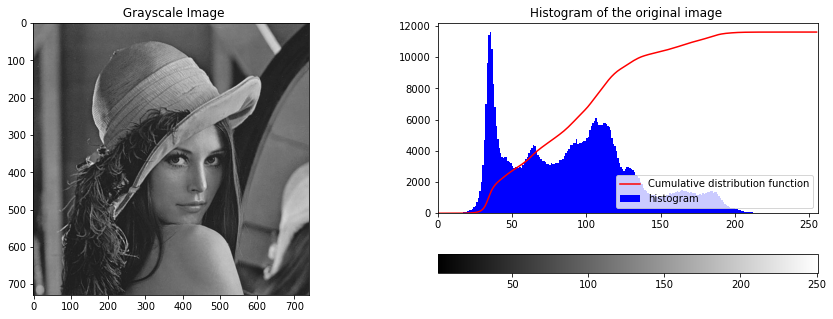

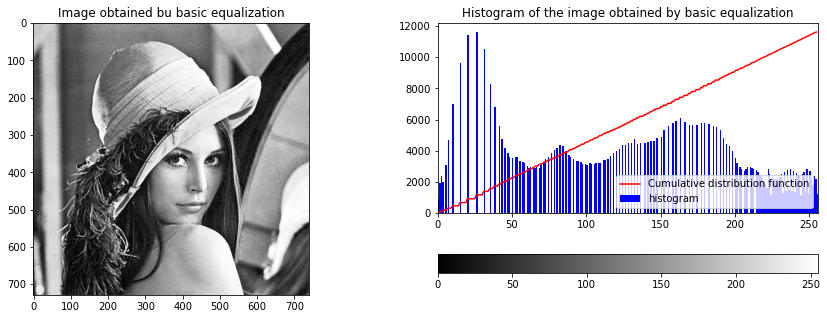

In [7]:
I = cv.imread(imageFolder+"/Lena.jpg",cv.IMREAD_COLOR)

# Convert BGR to RGB
I = cv.cvtColor(I, cv.COLOR_BGR2RGB)

# Convert RGB to grayscale
I = (rgb2gray(I)*256).astype('uint8')  # rgb2gray function 's output in skimage.color values is between 0 and 1

# Plot the colored image
plt.figure(figsize =(15,5))
plt.subplot(1,2,1); plt.imshow(I, cmap = 'gray'); plt.title(" Grayscale Image")

#calculating histogram
hist,bins = np.histogram(I.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.subplot(1,2,2); plt.plot(cdf_normalized, color = 'r')
plt.hist(I.flatten(),256,[0,256], color = 'b')
plt.title("Histogram of the original image "); plt.xlim([0,256])
plt.legend(('Cumulative distribution function','histogram'), loc = 'lower right')
plt.colorbar(orientation="horizontal"); plt.show()

equ = cv.equalizeHist(I)

# Plot the colored image
plt.figure(figsize =(15,5)); plt.subplot(1,2,1); plt.imshow(equ, cmap = 'gray'); 
plt.title("Image obtained bu basic equalization")

#calculating histogram
hist,bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.subplot(1,2,2); plt.plot(cdf_normalized, color = 'r')
plt.hist(equ.flatten(),256,[0,256], color = 'b')
plt.title("Histogram of the image obtained by basic equalization")
plt.xlim([0,256])
plt.legend(('Cumulative distribution function','histogram'), loc = 'lower right')
plt.colorbar(orientation="horizontal"); plt.show()


<div class="alert alert-info">
    

### Procedure :
    
In the previous cell, we did classic histogram equalization using the built in method of openCV, but as we can see, even though the cumulative distribution function is as linear as we want it to be, the histogram itself is not as flat as want.

To do an exact histogram equalization, we propose this idea : 
    
1. Flatten the image.
2. Sort the flatten array of the pixel intensities with an increasing order.
3. Sort the flatten array by indexes using the np.argsort funtion  : To keep the original positions of the pixels befor sorting the intensities.
4. Split the flatten array into equal amount of pixels in each bin (binSize = total ammount of pixels // 256)
5. Go through the splitted bins an assign an increasing amount of graylevel. Exp: bin1: graylevel = 0, bin2 : graylevel = 1
6. Iterate through the flatten array, one last time, to update the pixel intensities using the stored original indexes
7. Reshape the output image into the original shape

</div>


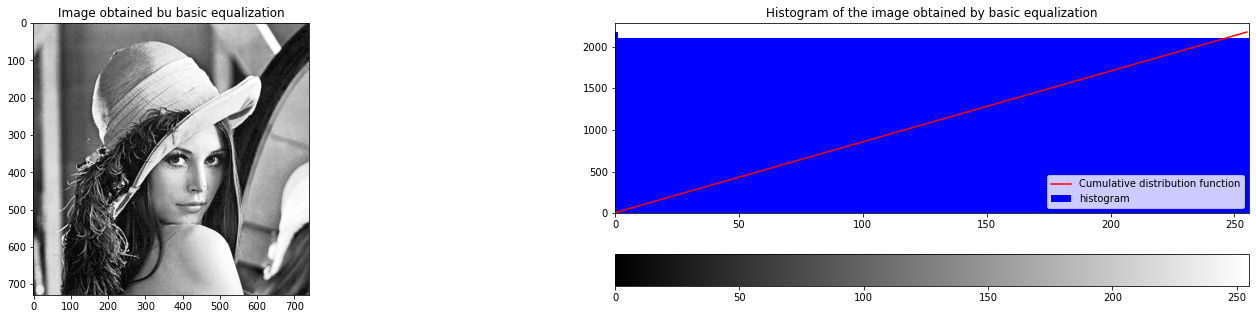

In [8]:
def equalizer(img):
    L, H = img.shape[0],img.shape[1]
    
    # Flatten the original image
    Iflatten = img.reshape(L*H)
    # Output image
    I = np.zeros(Iflatten.shape)
    # Sort the flatten array
    Isorted = np.sort(Iflatten, axis=None)
    # Sort the indexes of the values :  To keep in memory the place of the original pixels
    sortedIndexes = np.array(np.argsort(Iflatten)).reshape(L*H)
    # Define how much we want of pixels in each bin
    binSize = (L*H) //256  # The number of pixels we should have in each bin
    # Devide the flatten array and assign nex graylevel intensity
    grayLevel = 0
    for i in range(0, L*H,binSize ):
        Isorted[i : i + binSize] = grayLevel;
        grayLevel = grayLevel + 1
      
    # update pixel intensities
    for i in range(L*H):
        I[sortedIndexes[i]] = Isorted[i]
    # Reshape the image    
    I = I.reshape((L,H))        
    return I.astype(np.uint8)


I = cv.imread(imageFolder+"/Lena.jpg",cv.IMREAD_COLOR)

# Convert BGR to RGB
I = cv.cvtColor(I, cv.COLOR_BGR2RGB)

# Convert RGB to grayscale
I = (rgb2gray(I)*256).astype('uint8')  # rgb2gray function 's output in skimage.color values is between 0 and 1 so we have to scale it to 0-255

equ = equalizer(I)

# Plot the colored image
plt.figure(figsize =(25,5)); plt.subplot(1,2,1); plt.imshow(equ, cmap = 'gray')
plt.title("Image obtained bu basic equalization")

#calculating histogram
hist,bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.subplot(1,2,2)
plt.plot(cdf_normalized, color = 'r')
plt.hist(equ.flatten(),256,[0,256], color = 'b')
plt.title("Histogram of the image obtained by basic equalization")
plt.xlim([0,256])
plt.legend(('Cumulative distribution function','histogram'), loc = 'lower right')
plt.colorbar(orientation="horizontal")
plt.show()


---

## All RGB
This project consists in transforming a source image into a
transformed image containing multiple RGB color triplet.

(10.0, 30.0)

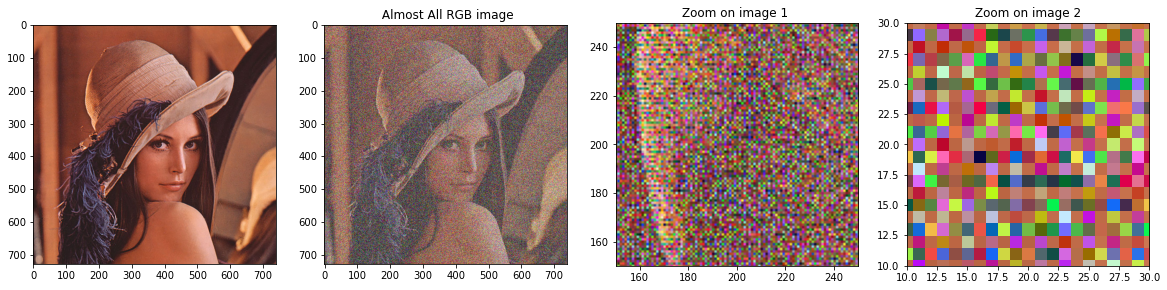

In [9]:
I = cv.imread(imageFolder+"/Lena.jpg",cv.IMREAD_COLOR)

# Convert BGR to RGB
plt.figure(figsize =(20,5))
plt.subplot(141);plt.imshow(cv.cvtColor(I.astype(np.uint8), cv.COLOR_BGR2RGB)) 

def allRGB(img):
    L, H = img.shape[0],img.shape[1]
    Iout = img.copy()

    # Loop through the image with 2 pixels at a time
    for j in range(0,H-1,2):
        for i in range(0,L-1,2):

            Iout[i+1, j, 0] = img[i+1, j, 0]
            Iout[i+1, j, 1] = random.randint(0, 255)
            Iout[i+1, j, 2] = random.randint(0, 255)
            
            Iout[i+1, j+1, 0] = random.randint(0, 255)
            Iout[i+1, j+1, 1] = img[i+1, j+1, 1]
            Iout[i+1, j+1, 2] = random.randint(0, 255)
            
            Iout[i, j+1, 0] = random.randint(0, 255)  
            Iout[i, j+1, 1] = random.randint(0, 255)
            Iout[i, j+1, 2] = img[i, j+1, 2]
    
    return Iout

imageAllRGB = allRGB(I)
plt.subplot(142);plt.imshow(cv.cvtColor(imageAllRGB.astype(np.uint8), cv.COLOR_BGR2RGB))
plt.title(" Almost All RGB image")

plt.subplot(143);plt.imshow(cv.cvtColor(imageAllRGB.astype(np.uint8), cv.COLOR_BGR2RGB))
plt.title("Zoom on image 1 ")
plt.ylim([150,250])
plt.xlim([150,250])

plt.subplot(144);plt.imshow(cv.cvtColor(imageAllRGB.astype(np.uint8), cv.COLOR_BGR2RGB))
plt.title("Zoom on image 2")
plt.xlim((10,30))
plt.ylim((10,30))
    

<div class="alert alert-info">
    

### ALMOST ALL RGB  :
    
Doing the All RGB can take a lot of computing power, and since I want to keep the the most of information of our original image, we might have to keep so pixels unchanged and change the rest.
    
**Procedure**
1. Read in the image.

2. Go through the image by groupe of 4 pixels  at a time

3. Each iteration :
    * keep the top left pixel unchanged
    * Set the top right and the two bottom pixels (of the 2*2 groupe of pixel) to random colors : I chose to copy one chanel (red, green or blue) from the origical image and randomize the remaining channels.

**To go further**
* To be able to print an color triplet ony once in the image, we might have to store all of the possibilities of combination created by the red, blue and green channels, to the iterate trough this array of colors only once.
    
* We can also consider groupes of pixels, in a way that we randomly pick 2 of 3 pixels to represent a color. This can make intresting patters within the image, where insted of having only square pixels, we can see rectangles, triangles..
    
</div>


--- 

## Measures
Perform all the measurements necessary to reproduce the part
shown in the figure piece.tif.

<div class="alert alert-info">
    

### Extract Forground and fill holes  :
    
**we can extract the background, by simply doing a floodfill operation from pixel (0, 0). Pixels that are not affected by the floodfill operation are necessarily inside the boundary. The flood-filled image when inverted and combined with the thresholded image gives the foreground mask**

    
1. Read in the image.

2. Threshold the input image to obtain a binary image.

3. Flood fill from pixel (0, 0). Notice the difference between the outputs of step 2 and step 3 is that the background in step 3 is now white.

4. Invert the flood filled image ( i.e. black becomes white and white becomes black ).

5. Combine the thresholded image with the inverted flood filled image using bitwise OR operation to obtain the final foreground mask with holes filled in. The image in Step 4 has some black areas inside the boundary. By design the image in Step 2 has those holes filled in. So we combine the two to get the mask.
    
</div>


https://learnopencv.com/filling-holes-in-an-image-using-opencv-python-c/

### Extract Forground with filled holes

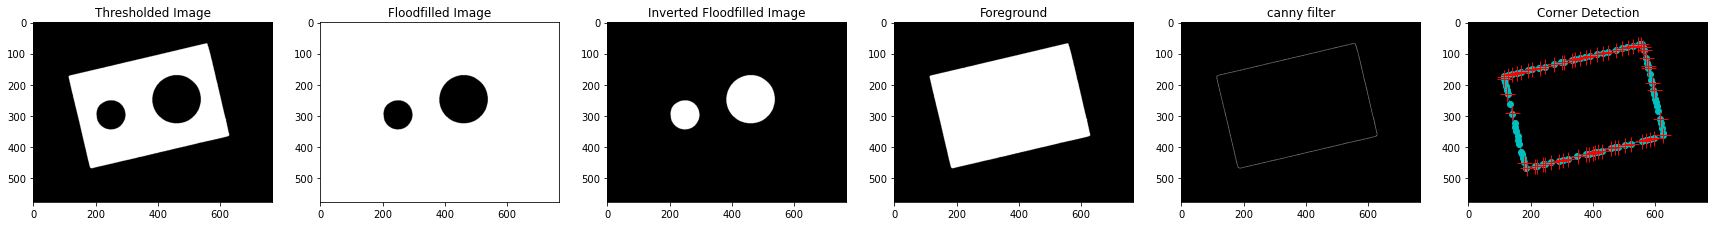

In [10]:
# Read image
im_in = cv.imread(imageFolder+"/pieceS3.tif", cv.IMREAD_GRAYSCALE);

# Threshold.
# Set values equal to or above 220 to 0.
# Set values below 220 to 255.

th, im_th = cv.threshold(im_in, 220, 255, cv.THRESH_BINARY_INV);

# Copy the thresholded image.
im_floodfill = im_th.copy()

# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

# Floodfill from point (0, 0)
cv.floodFill(im_floodfill, mask, (0,0), 255);

# Invert floodfilled image
im_floodfill_inv = cv.bitwise_not(im_floodfill)

# Combine the two images to get the foreground.
foregroud = im_th | im_floodfill_inv

edges = feature.canny(foregroud, sigma=3)

coords = corner_peaks(corner_harris(edges), min_distance=5, threshold_rel=0.02)
coords_subpix = corner_subpix(edges, coords, window_size=13)

# Display images.
plt.figure(figsize=(30,5))
plt.subplot(161); plt.imshow(im_th, cmap = 'gray');            plt.title("Thresholded Image")
plt.subplot(162); plt.imshow(im_floodfill, cmap = 'gray');     plt.title("Floodfilled Image")
plt.subplot(163); plt.imshow(im_floodfill_inv, cmap = 'gray'); plt.title("Inverted Floodfilled Image")
plt.subplot(164); plt.imshow(foregroud, cmap = 'gray');           plt.title("Foreground")
plt.subplot(165); plt.imshow(edges, cmap = 'gray');           plt.title("canny filter")
plt.subplot(166); plt.imshow(edges, cmap=plt.cm.gray); plt.plot(coords[:, 1], coords[:, 0],'oc'); plt.title("Corner Detection")
plt.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)

#print("Coordinates of the corners : \n",contours)

<div class="alert alert-info">
    

### Failed idea  :
    
My first idea was to detect the 4 corners of the rectangular filled foregroud, but this does not seem to work especially when the piece is horizontal.
    
### New idea : 
Detect the edges of the filled foreground and stock them to be used afterward to be filled in white and draw circles on.
    
</div>




### Edge Detection

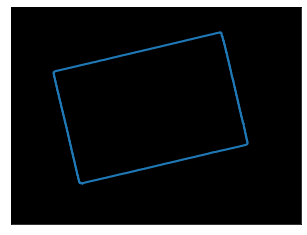

In [11]:
# Find contours at a constant value of 1
contours = measure.find_contours(foregroud, 1)
blank =  np.zeros(foregroud.shape)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(blank, cmap=plt.cm.gray)

def Swap(arr, start_index, last_index):
    arr[:, [start_index, last_index]] = arr[:, [last_index, start_index]]
    
# We swap the colums of each countour detected
for contour in contours:
    Swap(contour, 0, 1)
# Convert all elements to int    
contours = np.array(contours, dtype=np.int)
# Plot the countour
for contour in contours:
    ax.plot(contour[:, 0], contour[:, 1], linewidth=2,)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()  

<div class="alert alert-info">
    

### Find centroids and radius of the circuls  :

    
1. Invert the binary image in a way to set the circles to 1.

2. Label the inverted image and  Mesure the properties of the regions

3. Stock the radius and centroids of the circles in a list of objetcs of type Circle
    
</div>


### Find centroids and radius of the circuls

The number of assigned labels =  3
*****************************************
Region  0  :
averageRadius : length =  77.38587397614037
*****************************************
Region  1  :
averageRadius : length =  46.59026251680933


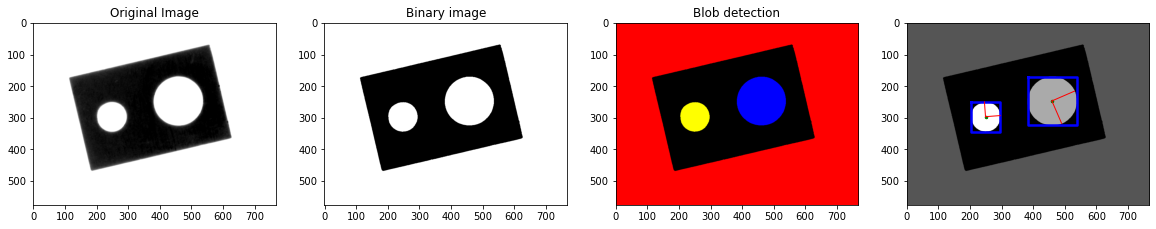

In [12]:
# Invert thresholded image
im_th = 255 - im_th

# Label the inverted image
im_labeled , nReg= label(im_th, connectivity = 2, return_num =True)
labeledRGB = label2rgb(im_labeled,bg_label=0,kind= 'overlay')
print("The number of assigned labels = ",nReg)

# Mesure the properties of the regions
regions = regionprops(im_labeled)
        
plt.figure(figsize =(20,5))
plt.subplot(1,4,1); plt.imshow(im_in, cmap = 'gray'); plt.title("Original Image") # Plot the colored image
plt.subplot(1,4,2); plt.imshow(im_th, cmap = 'gray'); plt.title("Binary image")  # Plot the binary image
plt.subplot(1,4,3); plt.imshow(labeledRGB); plt.title("Blob detection") # Plot the blobs

class Circle:
    def __init__(self,centroid,radius):
        self.centroid = centroid
        self.radius = radius

# Initiate a list of circles
circles = []
# Bounding box
plt.subplot(1,4,4);
plt.imshow(im_labeled, cmap=plt.cm.gray)
for i,props in enumerate(regions[1:3]):
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    
    plt.plot(bx, by, '-b', linewidth=2.5)
    plt.plot(x0, y0, '.g', markersize=5)
    plt.plot((x0, x1), (y0, y1), '-r', linewidth=1)
    plt.plot((x0, x2), (y0, y2), '-r', linewidth=1)
    print("*****************************************")
    print("Region ",i," :")
    axe1 = np.sqrt((x0-x1)**2 + (y0-y1)**2)
    axe2 = np.sqrt((x0-x2)**2 + (y0-y2)**2)
    averageRadius = (axe1 + axe2)/2
    print("averageRadius : length = ", (axe1 + axe2)/2)
    circles.append( Circle([y0,x0],averageRadius))
    
plt.show()

**We define a funtion that would allow us to draw white or black circles on a given image**

In [13]:
def drawCircles(I,rectObjectsList,color):
    imgOut = I.copy()
    for rect in rectObjectsList:
        """r, cint : Centre coordinate of circle.
        radiusint : Radius of circle."""
        rr, cc = disk( (int(rect.centroid[0]), int(rect.centroid[1])), int(rect.radius))
        if color == "white" :
            imgOut[rr, cc] = 255
        elif color == "black":
            imgOut[rr, cc] = 0
    return imgOut

### Test the algorithm

Text(0.5, 1.0, 'reconstructed piece')

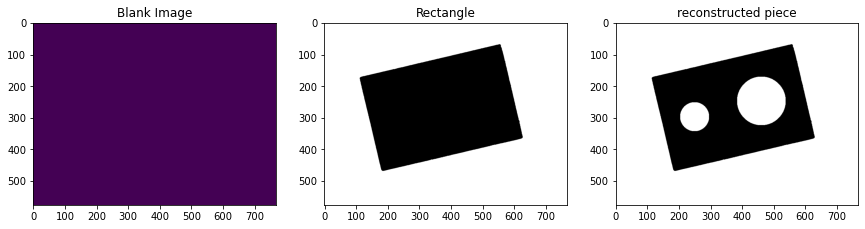

In [14]:
# Create a black canvas to draw on
im_blank = 255*np.ones(im_in.shape, dtype=np.uint8)

# Draw the rectangle
im_rect = im_blank.copy()
cv.drawContours(im_rect, contours, -1, (0,0,0), -1)

# Draw the circles
im_piece = drawCircles(im_rect,circles,"white")

# Plot the colored image
plt.figure(figsize =(20,5))
plt.subplot(1,4,1); plt.imshow(im_blank); plt.title("Blank Image")
plt.subplot(1,4,2); plt.imshow(im_rect, cmap = 'gray'); plt.title("Rectangle")
plt.subplot(1,4,3); plt.imshow(im_piece, cmap = 'gray'); plt.title("reconstructed piece")

---

### **Classification**
We propose to create a program (script) to classify the objects in
the RondelDent image into washers and cogwheels, each time displaying the
number of objects of each type. To do this, you must respectively:
- perform individual measurements on objects,
- analyse these measures,
- filter objects according to carefully chosen attributes,
- jointly display the number of objects of each type
Test the program on the two test images (RondelDent 1 and RondelDent 2)

#### Load image, convert it to binary image by thresholding and compute de connected components 

In [15]:
# load the image
image = cv.imread(imageFolder+"/rondeldent1.tif", cv.IMREAD_GRAYSCALE)
# convert it to binary image by thresholding 
th, im_th = cv.threshold(image, 220, 255, cv.THRESH_BINARY_INV);
# Apply the connected components algorithm
im_labeled , nReg= label(im_th, connectivity = 2, return_num =True)
labeledRGB = label2rgb(im_labeled,bg_label=0,kind= 'overlay',colors=['red','green','blue','cyan','magenta','yellow','orange','purple','gray'])

print("The number of assigned labels = ",nReg)

The number of assigned labels =  10


#### Compute interesting measutes for each detected blob

In [16]:
def get_shapeDescriptors(regions):
    
    properties = {
                     'label'              :  np.array([regions[i].label for i in range(len(regions))]),
                     'eccentricity' :  np.array([regions[i].eccentricity for i in range(len(regions))]),
                     #'perimeter'          :  np.array([regions[i].perimeter for i in range(len(regions))]),  
                     'area'               :  np.array([regions[i].area for i in range(len(regions))]),                 
                     'convex_filled_area' :  np.array([regions[i].convex_area - regions[i].filled_area for i in range(len(regions))]),
                     #'ratio_extent'       :  np.array([regions[i].extent for i in range(len(regions))]),
                     'solidity'     :  np.array([regions[i].solidity for i in range(len(regions))]), 
                     'compactness'        :  np.array([(regions[i].perimeter**2)/(4* np.pi*regions[i].filled_area) for i in range(len(regions))]),
                     'elongation'         :  np.array([(regions[i].bbox[2] - regions[i].bbox[0])/(regions[i].bbox[3] - regions[i].bbox[1]) for i in range(len(regions))])}     
                     #'countCoords'       :  len(regions.coords)}          # eventually grab these coordinates?

    return properties

<div class="alert alert-info">
    

> ### **elongation**:
The  ratio between the length and width of the object bounding box.
$$ elongation  = \frac{width_{bounding-box}}{length_{bounding-box}} $$
If the ratio is equal to 1, the object is roughly square or circularly shaped
    

> ### **Compactness**:
Objects which have an elliptical shape, or a boundary that is irregular rather than smooth, will decrease the measure.
$$ compactness  = \frac{perimeter^2}{4*\pi*area } $$
The measure takes a minimum value of 1 for a perfect circle
    
> ### **Solidity**:
A value of 1 signifies a solid object, and a value less than 1 will signify an object having an irregular boundary, or containing holes
    
> ### **Eccentricity**:
Eccentricity is the ratio of the length of the short (minor) axis to the length of the long (major) axis of an object
$$ elongation  = \frac{axislength_{short}}{axislength_{long}} $$
The result is a measure of object eccentricity, given as a value between 0 and 1
    
    
> ### **convex area - filled area**:
The difference between the convex area of an object which is the area of the
convex hull  that encloses the object and the area of the object with holes filled.
The area is the number of pixels in a shape
    
</div>

label    color  eccentricity   area  convex_filled_area  solidity  \
0      1      red      0.874404  30740                3882  0.738871   
1      2    green      0.130008  18096                 158  0.915650   
2      3     blue      0.178207  18196                 161  0.917045   
3      4     cyan      0.087375  22082                2985  0.857154   
4      5  magenta      0.997474   2431                3001  0.447533   
5      6   yellow      0.159610   2937                  67  0.744864   
6      7   orange      0.922989   4667                 299  0.939791   
7      8   purple      0.929737  40039                4853  0.891837   
8      9     gray      0.858183    366                  22  0.943299   
9     10     navy      0.752953     12                   1  0.923077   

   compactness  elongation predicted_class  
0     8.220011    0.479042            None  
1     1.817584    0.993711            None  
2     1.815051    0.981250            None  
3     4.808330    1.000000            None  
4    15.234334    0.093863            None  
5     2.853651    0.986486            None  
6     1.983841    1.307692            None  
7     3.111463    0.393519            None  
8     1.745442    0.459459            None  
9     0.613873    0.600000            None

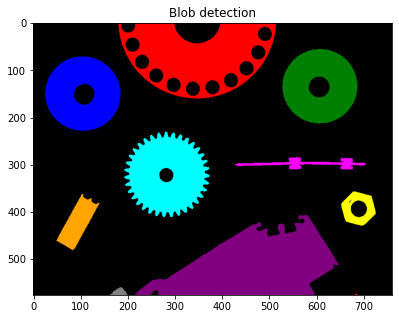

In [17]:
# Mesure the region properties using skimage.measure.
regions = regionprops(im_labeled)
# Extract and compute new measures 
props = get_shapeDescriptors(regions)
# Loading it into a dataframe
df = pd.DataFrame(props) 

# Using DataFrame.insert() to add a column
colors = ['red','green','blue','cyan','magenta','yellow','orange','purple','gray','navy']
predictedClass = ["None" for i in range(len(regions))]
df.insert(1, "color", colors[:len(regions)], True) 
df.insert(8, "predicted_class", predictedClass , True) 
# Plot image
plt.figure(figsize=(8,5)); plt.imshow(labeledRGB); plt.title("Blob detection") # Plot the blobs
df

<div class="alert alert-info">
    

#### The choosen idea to perform this classification :
    
1. Analyse the measures done on the data we have, and first identify all the pieces that are neither washers nor cogwheels. That is mosly done by takig into our advantage the fact that both the shapes we are lookin for are on the circular spectrum.
    
    * We start by small regions that might be found in the labeling process that do not correspond to any interesting peice.
    
    * Since an elongation = 1 represent a circle, we can consider all object whose elongation exceed 1.2or is less then 0.9 
    to be in the "other" category
    
    * We can also see from the table that only "Other" objects have an eccentricity higher then the circles so we can only  consider the objects with eccentricity less then 0.3 to be washers or cogwheels .    
    
    * in the case of "rondeldent1.tif" image, we have half of a circular peice with holes at the middle, so we take the solidity as a metric to identify it, since it is lower than 1, and in this case lower then the washers and cogwheels because it has more holes then the rest of the.
    
    * At this point we might have eliminated almost all "Other" peices, execpt the yellow nut [ecrou en français] which ressembles our circles in the majoority of metrics, but we can deal with it using its compactness and taking its size in our advantage.
    
</div>

label  color  eccentricity   area  convex_filled_area  solidity  \
1      2  green      0.130008  18096                 158  0.915650   
2      3   blue      0.178207  18196                 161  0.917045   
3      4   cyan      0.087375  22082                2985  0.857154   

   compactness  elongation predicted_class  
1     1.817584    0.993711            None  
2     1.815051    0.981250            None  
3     4.808330    1.000000            None

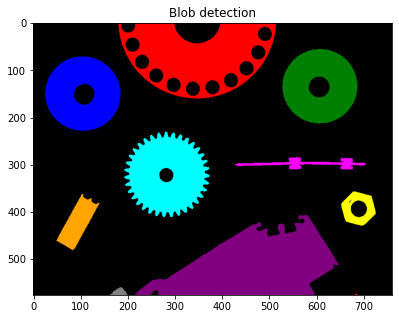

In [18]:
df = df[df["area"] > 1000]
df = df[(df["elongation"] > 0.9) & (df["elongation"] < 1.2)]
df = df[df["solidity"] > 0.8]
df = df[df["eccentricity"] < 0.3]
df = df[df["compactness"] < 5]

plt.figure(figsize=(8,5)); plt.imshow(labeledRGB); plt.title("Blob detection") # Plot the blobs

df

<div class="alert alert-info">
    

#### washers &  cogwheels classification :
    
2. Now that we have succeeded to identify the non interesting objects, we can proceed by the classification of the left peices into washers and cogwheels.
    
    * The most outstanding difference in metrics is the $converx_{area} - filled_{area}$.
    
    * If we take the pieces as if they were filled objects(without hole in the midle), the convex area of washers is almost equal to its real area, whereas for the cogwheels, there will be higher difference.
    
    * This diffence is seen  as convex_filled_area  metric in the table, so we could easly classify the remaining objects by thresholding it at a certain value depending on how deep are the teeth of the cogwheels.   

    
</div>

The number of assigned labels =  10


label  eccentricity   area  convex_filled_area  solidity  compactness  \
0      1      0.169478  21668                4920  0.678524     6.129289   
1      2      0.171679  18197                 161  0.917326     1.812339   
2      3      0.140308  18138                 151  0.916292     1.812660   
3      4      0.074234  22122                3002  0.856745     4.760872   
4      5      0.997455   2433                3004  0.447489    15.085070   
5      6      0.923361   4600                 290  0.940695     1.899301   
6      7      0.198192  17628                 159  0.913794     1.827931   
7      8      0.177516  18050                 150  0.912953     1.942924   
8      9      0.193760   2915                  82  0.740788     3.070509   
9     10      0.816497      3                   0  1.000000     0.309208   

   elongation    color predicted_class  
0    1.004950      red           Other  
1    0.993711    green          washer  
2    0.987421     blue          washer  
3    0.994505     cyan        cogwheel  
4    0.093863  magenta           Other  
5    0.917431   yellow           Other  
6    0.993631   orange          washer  
7    1.000000   purple          washer  
8    1.013889     gray           Other  
9    1.000000     navy           Other

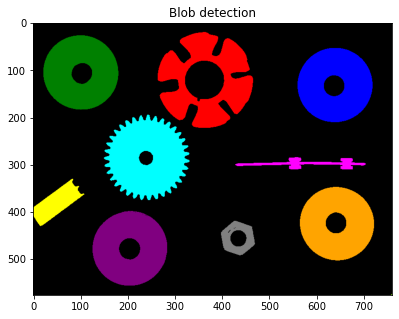

In [19]:
image = cv.imread(imageFolder+"/rondeldent2.tif", cv.IMREAD_GRAYSCALE)

def classify(image):
    
        th, im_th = cv.threshold(image, 220, 255, cv.THRESH_BINARY_INV);

        colors=['red','green','blue','cyan','magenta','yellow','orange','purple','gray','lawngreen']
        im_labeled , nReg = label(im_th, connectivity = 2, return_num =True)
        labeledRGB = label2rgb(im_labeled,bg_label=0,kind= 'overlay', colors = colors)
        print("The number of assigned labels = ",nReg)

        regions = regionprops(im_labeled)
        
        df = pd.DataFrame(get_shapeDescriptors(regions))
        colors = ['red','green','blue','cyan','magenta','yellow','orange','purple','gray','navy']
        df.insert(7, "color", colors[:len(regions)], True) 
        
        predictedClass = []
        for index, blob in df.iterrows():
            if 0.9 > blob['elongation'] > 1.2  or  blob['solidity'] < 0.8 or blob['eccentricity'] > 0.3  or  blob['area'] < 1000 or blob['compactness'] > 5 :
                predictedClass.append("Other")

            elif blob['convex_filled_area'] > 1000:
                predictedClass.append("cogwheel")
            else:
                predictedClass.append("washer")
                
        df.insert(8, "predicted_class", np.array(predictedClass) , True)

        return df,labeledRGB
    
df,labeledRGB  = classify(image)

plt.figure(figsize=(15,5))
plt.subplot(121); plt.imshow(labeledRGB); plt.title("Blob detection") 
            
df

<div class="alert alert-info">
    

#### Testing the algorithm on the rest of the images :
    
Now that we have succeeded to identify the non interesting objects, we can proceed by the classification of the left peices into washers and cogwheels.
    
</div>

<div class="alert alert-danger">

> The predicted class is listed on the last two colums of the dataframe
    </div>

The number of assigned labels =  10


label  eccentricity   area  convex_filled_area  solidity  compactness  \
0      1      0.874404  30740                3882  0.738871     8.220011   
1      2      0.130008  18096                 158  0.915650     1.817584   
2      3      0.178207  18196                 161  0.917045     1.815051   
3      4      0.087375  22082                2985  0.857154     4.808330   
4      5      0.997474   2431                3001  0.447533    15.234334   
5      6      0.159610   2937                  67  0.744864     2.853651   
6      7      0.922989   4667                 299  0.939791     1.983841   
7      8      0.929737  40039                4853  0.891837     3.111463   
8      9      0.858183    366                  22  0.943299     1.745442   
9     10      0.752953     12                   1  0.923077     0.613873   

   elongation    color predicted_class  
0    0.479042      red           Other  
1    0.993711    green          washer  
2    0.981250     blue          washer  
3    1.000000     cyan        cogwheel  
4    0.093863  magenta           Other  
5    0.986486   yellow           Other  
6    1.307692   orange           Other  
7    0.393519   purple           Other  
8    0.459459     gray           Other  
9    0.600000     navy           Other

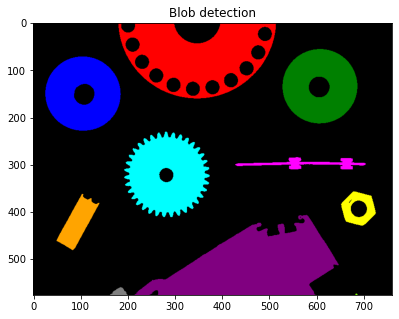

In [20]:
image = cv.imread(imageFolder+"/rondeldent1.tif", cv.IMREAD_GRAYSCALE)
df,labeledRGB  = classify(image)

plt.figure(figsize=(15,5))
plt.subplot(121); plt.imshow(labeledRGB); plt.title("Blob detection") 
            
df

The number of assigned labels =  9


label  eccentricity   area  convex_filled_area  solidity  compactness  \
0      1      0.997166   2327                2799  0.453960    15.419286   
1      2      0.165453   2894                  53  0.746839     2.580507   
2      3      0.060649  22251                2895  0.860940     4.673003   
3      4      0.144866  18052                 144  0.916345     1.814444   
4      5      0.110272  17747                 157  0.911505     1.840499   
5      6      0.924608   4646                 304  0.938586     1.855309   
6      7      0.175551  17469                 153  0.912696     1.827550   
7      8      0.070085  22045                2978  0.858484     4.608715   
8      9      0.000000      1                   0  1.000000     0.000000   

   elongation    color predicted_class  
0    1.503497      red           Other  
1    0.868421    green           Other  
2    0.994505     blue        cogwheel  
3    0.993671     cyan          washer  
4    1.000000  magenta          washer  
5    0.410256   yellow           Other  
6    0.987261   orange          washer  
7    0.994475   purple        cogwheel  
8    1.000000     gray           Other

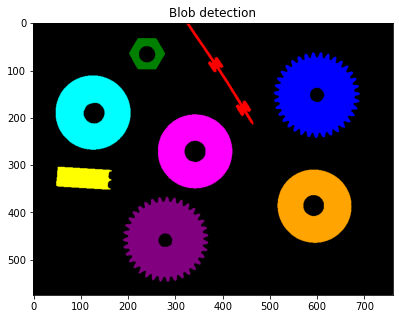

In [21]:
image = cv.imread(imageFolder+"/rondeldent.tif", cv.IMREAD_GRAYSCALE)
df,labeledRGB  = classify(image)

plt.figure(figsize=(15,5))
plt.subplot(121); plt.imshow(labeledRGB); plt.title("Blob detection") 
            
df

<div class="alert alert-info">
    
#### Conclusion : 
* Since we already had an idea on the shape of the peices and their size, we were able to succesfully classify them into 3 classes 
    1. Other
    2. Washer
    3. Cogweels
       

    
</div>